## Calculating Shape Features

In [13]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [4]:
def calculate_shape_features(mask, area_threshold=100):
    # convert mask to binary
    _, binary_mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)

    # finding contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, 
                                   cv2.RETR_EXTERNAL, 
                                   cv2.CHAIN_APPROX_SIMPLE)

    # initialize lists to store shape features
    solidity_list = []
    non_compactness_list = []
    circularity_list = []
    eccentricity_list = []

    for contour in contours:
        # calculating area and perimeter of the contour
        area = cv2.contourArea(contour)

        # skipping contours with very small area (below the threshold)
        if area < area_threshold:
            continue

        perimeter = cv2.arcLength(contour, True)

        # calculating solidity (ratio of area to convex hull area)
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)

        # skipping contours with very small convex hull area (below the threshold)
        if hull_area < area_threshold:
            continue

        solidity = area / hull_area

        # calculating non-compactness (ratio of area to the square of perimeter)
        non_compactness = area / (perimeter ** 2)

        # calculating circularity (4 * pi * area / perimeter^2)
        circularity = (4 * np.pi * area) / (perimeter ** 2)

        # calculatiing eccentricity (ratio of minor axis to major axis length)
        _, (major_axis, minor_axis), _ = cv2.fitEllipse(contour)
        eccentricity = minor_axis / major_axis

        # appending shape features to the respective lists
        solidity_list.append(solidity)
        non_compactness_list.append(non_compactness)
        circularity_list.append(circularity)
        eccentricity_list.append(eccentricity)

    return solidity_list, non_compactness_list, circularity_list, eccentricity_list

### Extracting Patches

In [35]:
def extract_patches(mask, rgb, area_threshold=100):
    # Convert mask to binary
    _, binary_mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)

    # Find connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask)

    # Initialize lists to store patches
    class1_patches = []
    class2_patches = []

    for label in range(1, num_labels):
        # Extract patch based on label
        patch_mask = (labels == label).astype(np.uint8)
        patch_rgb = cv2.bitwise_and(rgb, rgb, mask=patch_mask)

        # Calculate area of the patch
        patch_area = stats[label, cv2.CC_STAT_AREA]

        # Classify patches based on area
        if patch_area < area_threshold:
            class1_patches.append(patch_rgb)
        else:
            class2_patches.append(patch_rgb)

    return class1_patches, class2_patches

In [36]:
def process_images(folder_path):
    # List all the files in the folder
    file_list = os.listdir(folder_path)

    # Initialize lists to store results
    solidity_results = []
    non_compactness_results = []
    circularity_results = []
    eccentricity_results = []
    class1_patch_results = []
    class2_patch_results = []

    # Iterate through the files
    for filename in file_list:
        if filename.endswith("_depth.png"):
            # Generate corresponding mask, rgb, and truth filenames
            mask_filename = filename.replace("_depth.png", "_truth.png")
            rgb_filename = filename.replace("_depth.png", "_rgb.png")

            # Load images
            mask = cv2.imread(os.path.join(folder_path, mask_filename), cv2.IMREAD_GRAYSCALE)
            rgb = cv2.imread(os.path.join(folder_path, rgb_filename))

            # Calculate shape features
            solidity, non_compactness, circularity, eccentricity = calculate_shape_features(mask)

            # Extract patches
            class1_patches, class2_patches = extract_patches(mask, rgb)

            # Append the results to respective lists
            solidity_results.append(solidity)
            non_compactness_results.append(non_compactness)
            circularity_results.append(circularity)
            eccentricity_results.append(eccentricity)
            class1_patch_results.append(class1_patches)
            class2_patch_results.append(class2_patches)

    return (
        solidity_results,
        non_compactness_results,
        circularity_results,
        eccentricity_results,
        class1_patch_results,
        class2_patch_results,
    )

# Provide the path to the "onions" folder
folder_path = "onions/"
(
    solidity_results,
    non_compactness_results,
    circularity_results,
    eccentricity_results,
    class1_patch_results,
    class2_patch_results,
) = process_images(folder_path)


In [46]:
all_solidity = [val for sublist in solidity_results for val in sublist]
all_non_compactness = [val for sublist in non_compactness_results for val in sublist]
all_circularity = [val for sublist in circularity_results for val in sublist]
all_eccentricity = [val for sublist in eccentricity_results for val in sublist]

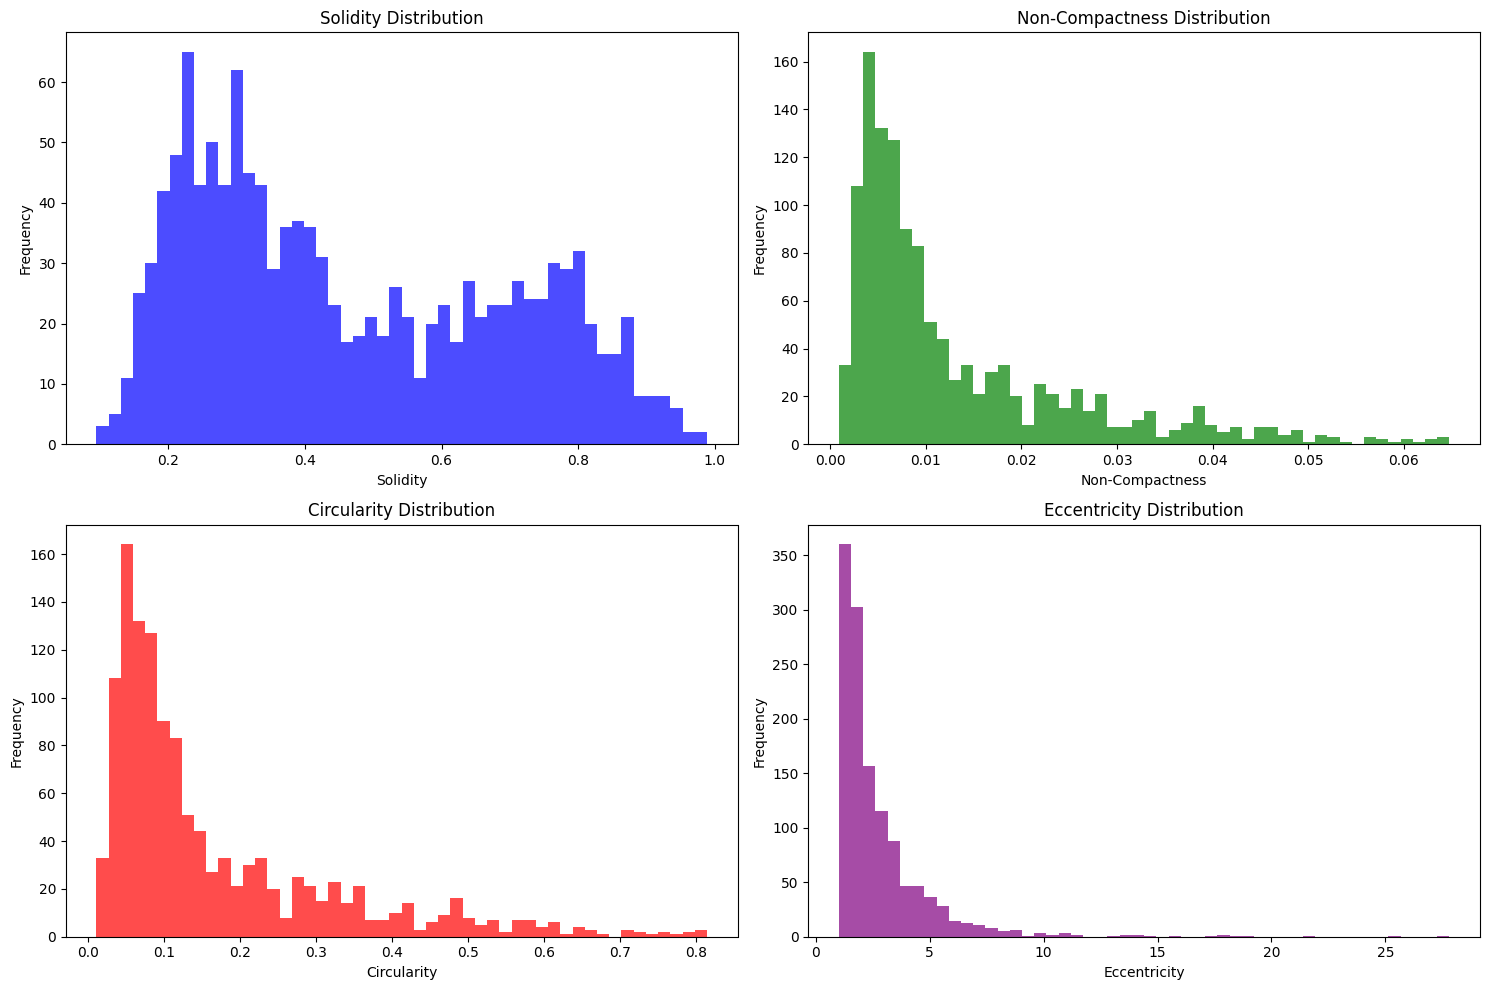

In [52]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(all_solidity, bins=50, color='blue', alpha=0.7)
plt.title('Solidity Distribution')
plt.xlabel('Solidity')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(all_non_compactness, bins=50, color='green', alpha=0.7)
plt.title('Non-Compactness Distribution')
plt.xlabel('Non-Compactness')
plt.ylabel('Frequency')


plt.subplot(2, 2, 3)
plt.hist(all_circularity, bins=50, color='red', alpha=0.7)
plt.title('Circularity Distribution')
plt.xlabel('Circularity')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(all_eccentricity, bins=50, color='purple', alpha=0.7)
plt.title('Eccentricity Distribution')
plt.xlabel('Eccentricity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()